In [1]:
!pip install hmmlearn biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving CoV-AbDab_080224.csv to CoV-AbDab_080224.csv


In [3]:
import pandas as pd
df = pd.read_csv("/content/CoV-AbDab_080224.csv")

In [4]:
#create training labels
def label_neutralization(row):
    neut = str(row["Neutralising Vs"]).strip()
    non = str(row["Not Neutralising Vs"]).strip()

    if neut not in ["", "nan", "NaN"] and neut != "None":
        return 1
    if non not in ["", "nan", "NaN"] and non != "None":
        return 0
    return None   # unknown

df["label"] = df.apply(label_neutralization, axis=1)
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

In [5]:
#extracting the CDRH3 sequences
df = df[df["CDRH3"].notna()] #remove rows with missing CDRH3
neutralizing_seqs = df[df["label"] == 1]["CDRH3"].tolist() #looks at label =1 (neutralizing), remove rows with CDRH3, makes it into list
non_neut_seqs = df[df["label"] == 0]["CDRH3"].tolist() #looks at label =0 (non- neutralizing), remove rows CDRH3, makes it into list

In [6]:
#converting amino acid sequences to integers
import numpy as np

AA = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa:i for i,aa in enumerate(AA)}

def one_hot(seq):
    arr = np.zeros((len(seq), 20), dtype=int)
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:
            arr[i, aa_to_idx[aa]] = 1
    return arr


In [7]:
neut_encoded = [one_hot(s) for s in neutralizing_seqs]
non_neut_encoded = [one_hot(s) for s in non_neut_seqs]

In [8]:
#default trained for 10 iterations
from hmmlearn.hmm import MultinomialHMM

np.random.seed(42)  # Added this for reproducibility

def train_hmm(seqs, n_states=6):
    model = MultinomialHMM(n_components=n_states, random_state=42) #take out random state if results are worse
    model.n_features = 20  # 20 amino acids

    lengths = [len(s) for s in seqs]
    X = np.vstack(seqs)  # shape = (total_len, 20)

    model.fit(X, lengths)
    return model


In [9]:
HMM_neut = train_hmm(neut_encoded, n_states=6)
HMM_non = train_hmm(non_neut_encoded, n_states=6)

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [10]:
# Print emission matrices
print("Neutralizing HMM emission matrix:")
print(HMM_neut.emissionprob_)


Neutralizing HMM emission matrix:
[[5.91620955e-02 9.54793900e-03 3.23517320e-01 5.42395893e-02
  4.99868124e-03 1.79378382e-01 1.67013267e-02 2.02116560e-02
  5.23282435e-03 5.09419866e-02 3.55024418e-03 2.29316296e-02
  3.26600812e-02 1.84592704e-02 2.18492224e-02 4.56627576e-02
  3.97967108e-02 4.99700766e-02 2.36777940e-02 1.75104125e-02]
 [8.83025898e-01 6.20814605e-04 1.25669304e-04 1.32504781e-07
  3.75308085e-04 6.22350717e-03 1.94543133e-03 7.29543083e-04
  3.09217861e-06 2.96024496e-03 3.10947672e-04 8.63380853e-03
  1.85844267e-06 5.61961287e-04 7.50738072e-06 7.88541362e-03
  3.55556497e-02 4.86434229e-02 6.20800863e-04 1.76898885e-03]
 [3.44488240e-03 2.26734025e-02 4.26595651e-03 1.08606482e-02
  2.68474245e-01 1.06825625e-01 1.59090499e-02 5.87382929e-03
  6.08903736e-03 2.72210720e-02 4.68665979e-02 4.18144521e-02
  4.56174234e-02 7.95013349e-03 2.50878522e-02 1.38476305e-01
  8.17480315e-03 8.86711751e-03 1.94112188e-03 2.03566444e-01]
 [4.74055200e-02 4.41849452e-04 2

In [11]:
print("\nNon-neutralizing HMM emission matrix:")
print(HMM_non.emissionprob_)


Non-neutralizing HMM emission matrix:
[[6.94531567e-02 7.39442205e-03 3.08986994e-01 4.47327207e-02
  8.50587796e-03 1.71638436e-01 1.73916844e-02 2.48102929e-02
  4.41109428e-03 5.20908879e-02 4.31931595e-03 2.12743435e-02
  3.07604216e-02 1.99820275e-02 2.63591954e-02 4.03236160e-02
  4.61623236e-02 6.14711924e-02 2.45569671e-02 1.53750306e-02]
 [8.96719897e-01 4.82270715e-09 3.82825093e-08 2.87868339e-07
  3.91136030e-04 3.66048237e-03 3.90256005e-04 2.56764866e-03
  1.28372009e-05 2.70792400e-06 2.38951959e-08 4.06825313e-03
  1.58215669e-06 2.70018008e-04 6.16118481e-04 6.24548654e-03
  3.46426765e-02 4.92212224e-02 4.07318071e-04 7.82004309e-04]
 [3.00826175e-03 1.63682805e-02 2.59020693e-03 4.02390345e-03
  2.64250794e-01 9.05590741e-02 1.34368563e-02 5.10248044e-03
  5.72618181e-03 2.58074249e-02 7.77814403e-02 5.55210951e-02
  3.24853205e-02 5.87909529e-03 2.32356200e-02 1.38593535e-01
  3.50816837e-03 6.34368892e-03 5.91877429e-04 2.25186694e-01]
 [5.50717546e-02 7.22670192e

In [12]:
import pandas as pd
import numpy as np

# List of amino acids
AA = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa:i for i,aa in enumerate(AA)}

# Function to create labeled DataFrame for emission matrix
def create_emission_df(emission_matrix, amino_acids=AA):
    n_states = emission_matrix.shape[0]
    df = pd.DataFrame(emission_matrix, columns=list(amino_acids))
    df.index = [f"State_{i+1}" for i in range(n_states)]
    return df

# Create labeled DataFrames
em_neut_df = create_emission_df(HMM_neut.emissionprob_)
em_non_df = create_emission_df(HMM_non.emissionprob_)

# Display the DataFrames
print("Neutralizing Antibodies Emission Probability Matrix:")
display(em_neut_df)

print("\nNon-Neutralizing Antibodies Emission Probability Matrix:")
display(em_non_df)


Neutralizing Antibodies Emission Probability Matrix:


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
State_1,0.059162,0.009548,0.323517,5.423959e-02,0.004999,0.179378,0.016701,0.020212,0.005233,0.050942,0.003550,0.022932,0.032660,0.018459,0.021849,0.045663,0.039797,0.049970,0.023678,0.017510
State_2,0.883026,0.000621,0.000126,1.325048e-07,0.000375,0.006224,0.001945,0.000730,0.000003,0.002960,0.000311,0.008634,0.000002,0.000562,0.000008,0.007885,0.035556,0.048643,0.000621,0.001769
State_3,0.003445,0.022673,0.004266,1.086065e-02,0.268474,0.106826,0.015909,0.005874,0.006089,0.027221,0.046867,0.041814,0.045617,0.007950,0.025088,0.138476,0.008175,0.008867,0.001941,0.203566
State_4,0.047406,0.000442,0.022382,3.120624e-02,0.049940,0.072107,0.010215,0.102562,0.005557,0.140546,0.063679,0.012711,0.055889,0.018991,0.036076,0.035979,0.058539,0.176363,0.014418,0.044993
State_5,0.078553,0.001815,0.002665,6.241127e-03,0.011802,0.018629,0.018782,0.008207,0.126849,0.007630,0.003741,0.004638,0.002125,0.003588,0.583982,0.035901,0.067095,0.016962,0.000200,0.000596
State_6,0.035769,0.027228,0.053091,9.914442e-03,0.013403,0.108638,0.029445,0.007116,0.005533,0.004414,0.000025,0.019316,0.056538,0.008382,0.035697,0.124083,0.041792,0.010807,0.059829,0.348980



Non-Neutralizing Antibodies Emission Probability Matrix:


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
State_1,0.069453,7.394422e-03,3.089870e-01,4.473272e-02,0.008506,0.171638,0.017392,0.024810,0.004411,0.052091,4.319316e-03,0.021274,0.030760,0.019982,0.026359,0.040324,0.046162,0.061471,0.024557,0.015375
State_2,0.896720,4.822707e-09,3.828251e-08,2.878683e-07,0.000391,0.003660,0.000390,0.002568,0.000013,0.000003,2.389520e-08,0.004068,0.000002,0.000270,0.000616,0.006245,0.034643,0.049221,0.000407,0.000782
State_3,0.003008,1.636828e-02,2.590207e-03,4.023903e-03,0.264251,0.090559,0.013437,0.005102,0.005726,0.025807,7.778144e-02,0.055521,0.032485,0.005879,0.023236,0.138594,0.003508,0.006344,0.000592,0.225187
State_4,0.055072,7.226702e-04,1.730952e-02,3.065071e-02,0.058151,0.074157,0.007076,0.093169,0.005121,0.127022,4.921378e-02,0.008655,0.079036,0.021747,0.039785,0.043079,0.057776,0.185341,0.021962,0.024955
State_5,0.032092,1.492877e-03,1.660265e-03,1.497469e-02,0.007003,0.032658,0.022077,0.013735,0.152522,0.006932,5.900079e-03,0.003050,0.003461,0.006581,0.590200,0.035866,0.060625,0.008697,0.000460,0.000014
State_6,0.026862,3.052444e-02,4.905440e-02,2.977453e-03,0.007116,0.118507,0.029099,0.003312,0.005542,0.001843,1.261336e-05,0.022553,0.042440,0.004554,0.019856,0.132909,0.032305,0.005660,0.052173,0.412699


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
)

# ============================================================================
# SECTION 1: BIOCHEMICAL FEATURE EXTRACTION
# ============================================================================

class BiochemicalFeatureExtractor:
    """Extract biochemical descriptors from CDRH3 sequences"""

    HYDROPHOBICITY = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }

    CHARGE = {
        'A': 0, 'R': 1, 'N': 0, 'D': -1, 'C': 0,
        'Q': 0, 'E': -1, 'G': 0, 'H': 0.5, 'I': 0,
        'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0,
        'S': 0, 'T': 0, 'W': 0, 'Y': 0, 'V': 0
    }

    AROMATIC = {'F', 'W', 'Y', 'H'}
    POLAR = {'S', 'T', 'N', 'Q', 'C'}
    ALIPHATIC = {'A', 'V', 'I', 'L', 'M'}

    MOLECULAR_WEIGHT = {
        'A': 89.1, 'R': 174.2, 'N': 132.1, 'D': 133.1, 'C': 121.2,
        'Q': 146.2, 'E': 147.1, 'G': 75.1, 'H': 155.2, 'I': 131.2,
        'L': 131.2, 'K': 146.2, 'M': 149.2, 'F': 165.2, 'P': 115.1,
        'S': 105.1, 'T': 119.1, 'W': 204.2, 'Y': 181.2, 'V': 117.1
    }

    def __init__(self):
        self.feature_names = []

    def extract_features(self, sequence):
        features = {}

        features['length'] = len(sequence)
        hydros = [self.HYDROPHOBICITY.get(aa, 0) for aa in sequence]
        charges = [self.CHARGE.get(aa, 0) for aa in sequence]

        features['hydrophobicity_mean'] = np.mean(hydros)
        features['hydrophobicity_std'] = np.std(hydros)
        features['charge_total'] = sum(charges)
        features['charge_mean'] = features['charge_total'] / len(sequence)

        features['aromatic_count'] = sum(1 for aa in sequence if aa in self.AROMATIC)
        features['aromatic_fraction'] = features['aromatic_count'] / len(sequence)

        features['polar_count'] = sum(1 for aa in sequence if aa in self.POLAR)
        features['polar_fraction'] = features['polar_count'] / len(sequence)

        features['aliphatic_count'] = sum(1 for aa in sequence if aa in self.ALIPHATIC)
        features['aliphatic_fraction'] = features['aliphatic_count'] / len(sequence)

        features['molecular_weight'] = sum([self.MOLECULAR_WEIGHT.get(aa, 0) for aa in sequence])
        features['avg_residue_weight'] = features['molecular_weight'] / len(sequence)

        n_third = len(sequence) // 3
        if n_third > 0:
            n_term = sequence[:n_third]
            c_term = sequence[-n_third:]
            middle = sequence[n_third:-n_third] if len(sequence) > 2 * n_third else sequence

            features['n_term_hydrophobicity'] = np.mean([self.HYDROPHOBICITY.get(aa, 0) for aa in n_term])
            features['c_term_hydrophobicity'] = np.mean([self.HYDROPHOBICITY.get(aa, 0) for aa in c_term])
            features['middle_hydrophobicity'] = np.mean(
                [self.HYDROPHOBICITY.get(aa, 0) for aa in middle]
            ) if middle else 0

            features['n_term_charge'] = sum([self.CHARGE.get(aa, 0) for aa in n_term]) / len(n_term)
            features['c_term_charge'] = sum([self.CHARGE.get(aa, 0) for aa in c_term]) / len(c_term)
        else:
            features['n_term_hydrophobicity'] = features['hydrophobicity_mean']
            features['c_term_hydrophobicity'] = features['hydrophobicity_mean']
            features['middle_hydrophobicity'] = features['hydrophobicity_mean']
            features['n_term_charge'] = features['charge_mean']
            features['c_term_charge'] = features['charge_mean']

        return features

    def extract_batch(self, sequences):
        feature_list = [self.extract_features(seq) for seq in sequences]
        df = pd.DataFrame(feature_list)
        self.feature_names = df.columns.tolist()
        return df

# ============================================================================
# SECTION 2: HMM MOTIF PROBABILITY EXTRACTION
# ============================================================================

def extract_hmm_emission_features(sequences, emission_probs_neut, emission_probs_non_neut,
                                  amino_acids='ACDEFGHIKLMNPQRSTVWY'):
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    n_states = emission_probs_neut.shape[0]

    motif_features = []

    for seq in sequences:
        features = {}

        for state_idx in range(n_states):
            neut_emissions = []
            non_neut_emissions = []

            for aa in seq:
                if aa in aa_to_idx:
                    aa_idx = aa_to_idx[aa]
                    neut_emissions.append(emission_probs_neut[state_idx, aa_idx])
                    non_neut_emissions.append(emission_probs_non_neut[state_idx, aa_idx])

            if neut_emissions:
                features[f'state_{state_idx}_neut_emission_mean'] = np.mean(neut_emissions)
                features[f'state_{state_idx}_non_neut_emission_mean'] = np.mean(non_neut_emissions)
                features[f'state_{state_idx}_emission_ratio'] = (
                    np.mean(neut_emissions) / (np.mean(non_neut_emissions) + 1e-10)
                )
                features[f'state_{state_idx}_neut_emission_max'] = np.max(neut_emissions)
                features[f'state_{state_idx}_non_neut_emission_max'] = np.max(non_neut_emissions)

        log_prob_neut = 0.0
        log_prob_non_neut = 0.0

        for aa in seq:
            if aa in aa_to_idx:
                aa_idx = aa_to_idx[aa]
                log_prob_neut += np.log(np.max(emission_probs_neut[:, aa_idx]) + 1e-300)
                log_prob_non_neut += np.log(np.max(emission_probs_non_neut[:, aa_idx]) + 1e-300)

        features['log_likelihood_neut'] = log_prob_neut
        features['log_likelihood_non_neut'] = log_prob_non_neut
        features['log_likelihood_ratio'] = log_prob_neut - log_prob_non_neut

        motif_features.append(features)

    return pd.DataFrame(motif_features)

# ============================================================================
# SECTION 3: INTEGRATED PIPELINE
# ============================================================================

def add_interaction_features(X,
                             biochem_cols=None,
                             motif_cols=None,
                             max_motif=10):
    X = X.copy()

    if biochem_cols is None:
        biochem_cols = [
            c for c in X.columns
            if any(k in c for k in [
                'hydrophobicity', 'charge', 'aromatic_fraction',
                'polar_fraction', 'aliphatic_fraction', 'length'
            ])
        ]

    if motif_cols is None:
        all_motif = [c for c in X.columns
                     if c.startswith('state_') or 'log_likelihood' in c]
        motif_cols = all_motif[:max_motif]

    print(f"Adding interactions between {len(biochem_cols)} biochem "
          f"and {len(motif_cols)} motif features")

    inter_cols = {}
    for b in biochem_cols:
        for m in motif_cols:
            inter_name = f'{b}__X__{m}'
            inter_cols[inter_name] = X[b] * X[m]

    inter_df = pd.DataFrame(inter_cols, index=X.index)
    X = pd.concat([X, inter_df], axis=1)

    print(f"Total features after interactions: {X.shape[1]}")
    return X


def create_integrated_feature_matrix(sequences, labels, emission_probs_neut, emission_probs_non_neut):
    print("Extracting HMM emission-based features...")
    motif_features = extract_hmm_emission_features(
        sequences, emission_probs_neut, emission_probs_non_neut
    )

    print("Extracting biochemical features...")
    extractor = BiochemicalFeatureExtractor()
    biochem_features = extractor.extract_batch(sequences)

    X = pd.concat([motif_features, biochem_features], axis=1)
    y = np.array(labels)

    X = add_interaction_features(X)

    feature_names = X.columns.tolist()

    print(f"Total features: {len(feature_names)}")
    print(f"  - Motif features: {len(motif_features.columns)}")
    print(f"  - Biochemical features: {len(biochem_features.columns)}")

    return X, y, feature_names

# ============================================================================
# SECTION 4: FAST BAYESIAN MODEL USING MAP ESTIMATION (NO CV, NO HESSIAN)
# ============================================================================

class FastBayesianNeutralizationModel:
    """
    Logistic regression with L2 regularization (Gaussian prior).
    No CV, no Hessian; fast and stable.
    """

    def __init__(self, prior_scale=2.5):
        self.prior_scale = prior_scale
        self.lambda_reg = 1.0 / (prior_scale ** 2)
        self.coef_ = None
        self.intercept_ = None
        self.feature_names = None
        self.scaler = StandardScaler()
        self.std_errors_ = None
        self.best_thresh_ = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def _negative_log_posterior(self, params, X, y):
        intercept = params[0]
        coef = params[1:]

        z = intercept + X @ coef
        p = self._sigmoid(z)

        epsilon = 1e-15
        p = np.clip(p, epsilon, 1 - epsilon)

        N = len(y)
        N_pos = np.sum(y == 1)
        N_neg = N - N_pos
        if N_pos == 0 or N_neg == 0:
            w_pos = 1.0
            w_neg = 1.0
        else:
            w_pos = N / (2.0 * N_pos)
            w_neg = N / (2.0 * N_neg)

        nll = -np.sum(
            w_pos * y * np.log(p) +
            w_neg * (1 - y) * np.log(1 - p)
        )

        nlp = 0.5 * self.lambda_reg * np.sum(coef ** 2)

        return nll + nlp

    def fit(self, X, y, feature_names):
        self.feature_names = feature_names

        X_scaled = self.scaler.fit_transform(X)
        n_features = X_scaled.shape[1]
        init_params = np.zeros(n_features + 1)

        print("Fitting model using MAP estimation...")
        print(f"Prior scale (σ): {self.prior_scale}")
        print(f"Regularization strength (λ): {self.lambda_reg:.4f}")

        result = minimize(
            self._negative_log_posterior,
            init_params,
            args=(X_scaled, y),
            method='L-BFGS-B',
            options={'maxiter': 1000}
        )

        if result.success:
            print("✓ Optimization converged successfully!")
        else:
            print("⚠️  Warning: Optimization may not have fully converged")

        self.intercept_ = result.x[0]
        self.coef_ = result.x[1:]

        # Dummy SDs so coefficient summary still works
        self.std_errors_ = np.ones_like(result.x) * 0.01

        return self

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        z = self.intercept_ + X_scaled @ self.coef_
        prob = self._sigmoid(z)

        if self.std_errors_ is not None:
            z_std = np.sqrt(np.sum((X_scaled * self.std_errors_[1:]) ** 2, axis=1))
            prob_lower = self._sigmoid(z - 1.96 * z_std)
            prob_upper = self._sigmoid(z + 1.96 * z_std)
        else:
            prob_lower = np.full_like(prob, np.nan)
            prob_upper = np.full_like(prob, np.nan)

        return prob, prob_lower, prob_upper

    def get_coefficient_summary(self):
        feature_list = ['alpha'] + self.feature_names
        summary = pd.DataFrame({
            'feature': feature_list,
            'mean': np.concatenate([[self.intercept_], self.coef_]),
            'sd': self.std_errors_,
        })
        summary['ci_lower'] = summary['mean'] - 1.96 * summary['sd']
        summary['ci_upper'] = summary['mean'] + 1.96 * summary['sd']
        return summary

    def plot_coefficient_forest(self, top_n=20):
        coef_summary = self.get_coefficient_summary()
        coef_summary = coef_summary[coef_summary['feature'] != 'alpha']
        coef_summary['abs_mean'] = np.abs(coef_summary['mean'])
        coef_summary = coef_summary.sort_values('abs_mean', ascending=False).head(top_n)

        fig, ax = plt.subplots(figsize=(10, 8))
        y_pos = np.arange(len(coef_summary))
        ax.errorbar(
            coef_summary['mean'],
            y_pos,
            xerr=[coef_summary['mean'] - coef_summary['ci_lower'],
                  coef_summary['ci_upper'] - coef_summary['mean']],
            fmt='o',
            capsize=5,
            capthick=2
        )

        ax.axvline(0, linestyle='--', alpha=0.5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(coef_summary['feature'])
        ax.set_xlabel('Coefficient Value (Standardized)', fontsize=12)
        ax.set_title(f'Top {top_n} Features by Coefficient Magnitude', fontsize=14)
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        return fig

# ============================================================================
# SECTION 5: MODEL EVALUATION
# ============================================================================

def evaluate_model(model, X_test, y_test):
    print("\n" + "=" * 60)
    print("MODEL EVALUATION")
    print("=" * 60)

    y_pred_proba, _, _ = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    best_thresh = thresholds[best_idx]
    print(f"\nOptimal threshold (Youden J): {best_thresh:.3f}")

    model.best_thresh_ = best_thresh
    y_pred = (y_pred_proba >= best_thresh).astype(int)

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {auc:.4f}")

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {bal_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(
        y_test,
        y_pred,
        target_names=['Non-Neutralizing', 'Neutralizing']
    ))

    cm = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix')
    ax1.set_xticklabels(['Non-Neut', 'Neut'])
    ax1.set_yticklabels(['Non-Neut', 'Neut'])

    ax2.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return auc, y_pred_proba, best_thresh

# ============================================================================
# SECTION 6: MAIN EXECUTION (NO PRIOR TUNING)
# ============================================================================

def main_example_fast(emission_probs_neut, emission_probs_non_neut, sequences, labels):
    print("=" * 60)
    print("FAST BAYESIAN LOGISTIC REGRESSION (MAP ESTIMATION)")
    print("=" * 60)

    print(f"\n✓ Loaded emission matrices:")
    print(f"  - Neutralizing HMM: {emission_probs_neut.shape}")
    print(f"  - Non-neutralizing HMM: {emission_probs_non_neut.shape}")
    print(f"\n✓ Data summary:")
    print(f"  - Total sequences: {len(sequences)}")
    print(f"  - Neutralizing: {sum(labels == 1)}")
    print(f"  - Non-neutralizing: {sum(labels == 0)}")

    print("\n" + "=" * 60)
    print("EXTRACTING FEATURES")
    print("=" * 60 + "\n")

    X_full, y, feature_names = create_integrated_feature_matrix(
        sequences, labels, emission_probs_neut, emission_probs_non_neut
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_full.values, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    import time
    start_time = time.time()

    # Single fit, fixed prior_scale
    model = FastBayesianNeutralizationModel(prior_scale=2.5)
    model.fit(X_train, y_train, feature_names)

    elapsed_time = time.time() - start_time
    print(f"\n✓ Training completed in {elapsed_time:.1f} seconds!")

    auc, y_pred_proba, best_thresh = evaluate_model(model, X_test, y_test)

    print("\n" + "=" * 60)
    print("COEFFICIENT SUMMARY (Top 15)")
    print("=" * 60)
    coef_summary = model.get_coefficient_summary()
    print(coef_summary.head(15).to_string(index=False))

    print("\n" + "=" * 60)
    print("GENERATING VISUALIZATIONS")
    print("=" * 60)
    model.plot_coefficient_forest(top_n=15)
    plt.show()

    # If you have plot_prediction_uncertainty defined elsewhere, you can still call it:
    try:
        y_pred_mean, y_pred_lower, y_pred_upper = model.predict_proba(X_test)
        plot_prediction_uncertainty(y_test, y_pred_mean, y_pred_lower, y_pred_upper)
    except NameError:
        pass

    print("\n✅ Fast analysis complete!")
    print("\nKey outputs:")
    print("- MAP coefficient estimates")
    print("- Feature importance rankings")
    print("- Model performance metrics")

    return model, coef_summary, X_full, feature_names

print("Super-fast Bayesian model loaded! Use main_example_fast() instead of main_example().")

Super-fast Bayesian model loaded! Use main_example_fast() instead of main_example().


PREPARING DATA FROM AIM 1

✓ Loaded neutralizing HMM emissions: (6, 20)
✓ Loaded non-neutralizing HMM emissions: (6, 20)
✓ Total sequences: 8914
  - Neutralizing: 6373
  - Non-neutralizing: 2541

RUNNING FAST AIM 2 ANALYSIS
FAST BAYESIAN LOGISTIC REGRESSION (MAP ESTIMATION)

✓ Loaded emission matrices:
  - Neutralizing HMM: (6, 20)
  - Non-neutralizing HMM: (6, 20)

✓ Data summary:
  - Total sequences: 8914
  - Neutralizing: 6373
  - Non-neutralizing: 2541

EXTRACTING FEATURES

Extracting HMM emission-based features...
Extracting biochemical features...
Adding interactions between 13 biochem and 10 motif features
Total features after interactions: 181
Total features: 181
  - Motif features: 33
  - Biochemical features: 18

Training set: 7131 samples
Test set: 1783 samples
Fitting model using MAP estimation...
Prior scale (σ): 2.5
Regularization strength (λ): 0.1600
⚠️  Warning: Optimization may not have fully converged

✓ Training completed in 39.7 seconds!

MODEL EVALUATION

Optimal t

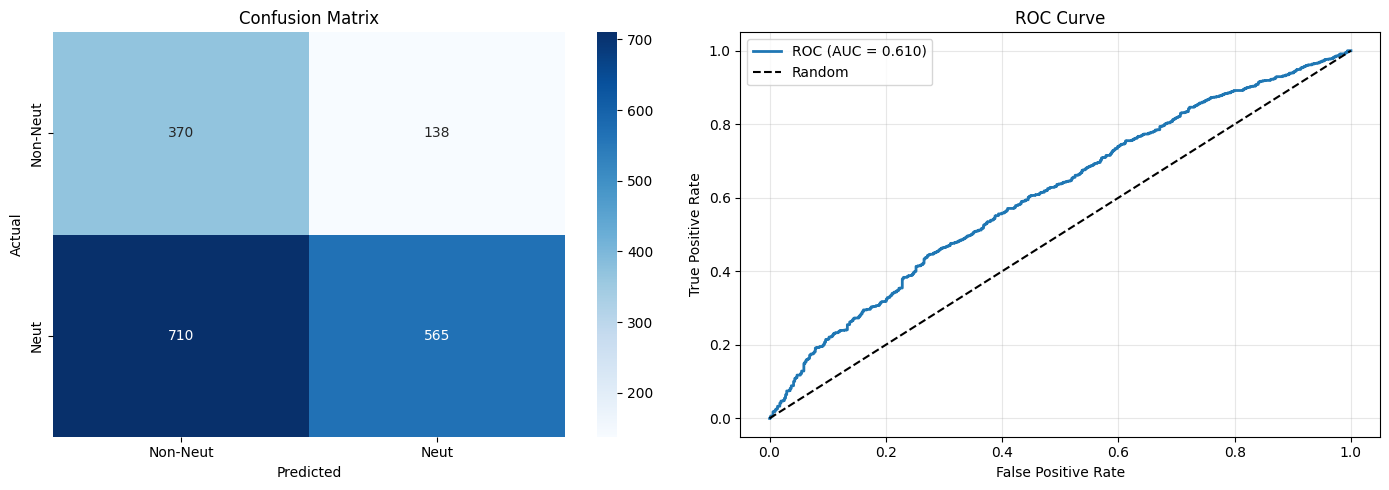


COEFFICIENT SUMMARY (Top 15)
                       feature      mean   sd  ci_lower  ci_upper
                         alpha  0.063698 0.01  0.044098  0.083298
    state_0_neut_emission_mean -0.158401 0.01 -0.178001 -0.138801
state_0_non_neut_emission_mean -0.226352 0.01 -0.245952 -0.206752
        state_0_emission_ratio  0.055255 0.01  0.035655  0.074855
     state_0_neut_emission_max -0.193748 0.01 -0.213348 -0.174148
 state_0_non_neut_emission_max -0.242854 0.01 -0.262454 -0.223254
    state_1_neut_emission_mean -0.453172 0.01 -0.472772 -0.433572
state_1_non_neut_emission_mean -0.436737 0.01 -0.456337 -0.417137
        state_1_emission_ratio  0.030606 0.01  0.011006  0.050206
     state_1_neut_emission_max  0.023894 0.01  0.004294  0.043494
 state_1_non_neut_emission_max  0.022966 0.01  0.003366  0.042566
    state_2_neut_emission_mean -0.055573 0.01 -0.075173 -0.035973
state_2_non_neut_emission_mean -0.262705 0.01 -0.282305 -0.243105
        state_2_emission_ratio -0.046961 0.01 

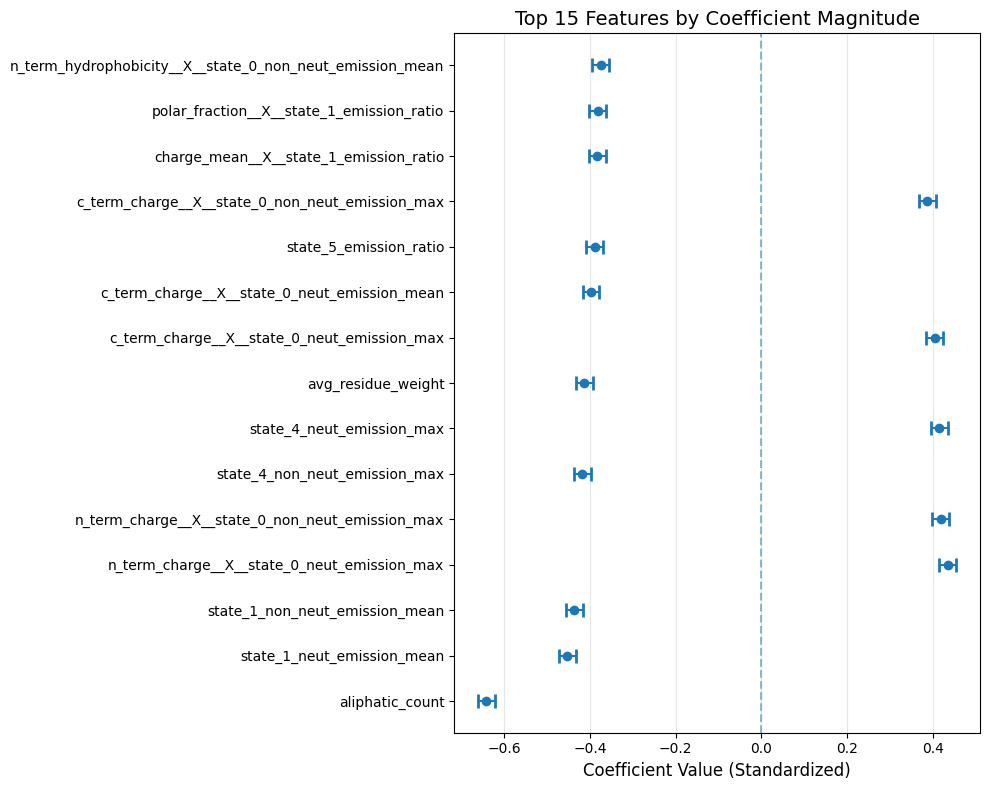


✅ Fast analysis complete!

Key outputs:
- MAP coefficient estimates
- Feature importance rankings
- Model performance metrics

FEATURE IMPORTANCE BY CATEGORY

🧬 TOP 10 HMM MOTIF FEATURES:
----------------------------------------------------------------------
↓ state_1_neut_emission_mean                    β= -0.453  95% CI: [-0.473, -0.434]
↓ state_1_non_neut_emission_mean                β= -0.437  95% CI: [-0.456, -0.417]
↑ n_term_charge__X__state_0_neut_emission_max   β=  0.435  95% CI: [ 0.415,  0.455]
↑ n_term_charge__X__state_0_non_neut_emission_max β=  0.418  95% CI: [ 0.399,  0.438]
↓ state_4_non_neut_emission_max                 β= -0.418  95% CI: [-0.437, -0.398]
↑ state_4_neut_emission_max                     β=  0.415  95% CI: [ 0.396,  0.435]
↑ c_term_charge__X__state_0_neut_emission_max   β=  0.405  95% CI: [ 0.385,  0.424]
↓ c_term_charge__X__state_0_neut_emission_mean  β= -0.398  95% CI: [-0.418, -0.379]
↓ state_5_emission_ratio                        β= -0.389  95% CI:

In [14]:
# ==============================================================================
# FAST AIM 2: RUN BAYESIAN LOGISTIC REGRESSION (MAP ESTIMATION)
# ==============================================================================
# This runs in 1-2 minutes instead of 15+ minutes!
# ==============================================================================

print("="*70)
print("PREPARING DATA FROM AIM 1")
print("="*70)

# Extract emission probability matrices from your trained HMMs
emission_probs_neut = HMM_neut.emissionprob_
emission_probs_non_neut = HMM_non.emissionprob_

# Combine sequences and create labels
all_sequences = neutralizing_seqs + non_neut_seqs
all_labels = np.array([1]*len(neutralizing_seqs) + [0]*len(non_neut_seqs))

print(f"\n✓ Loaded neutralizing HMM emissions: {emission_probs_neut.shape}")
print(f"✓ Loaded non-neutralizing HMM emissions: {emission_probs_non_neut.shape}")
print(f"✓ Total sequences: {len(all_sequences)}")
print(f"  - Neutralizing: {sum(all_labels == 1)}")
print(f"  - Non-neutralizing: {sum(all_labels == 0)}")

# ==============================================================================
# RUN THE FAST ANALYSIS (uses MAP instead of MCMC)
# ==============================================================================

print("\n" + "="*70)
print("RUNNING FAST AIM 2 ANALYSIS")
print("="*70)

# Run the fast analysis
model, coef_summary, X_full, feature_names = main_example_fast(
    emission_probs_neut,
    emission_probs_non_neut,
    all_sequences,
    all_labels
)

# ==============================================================================
# FEATURE IMPORTANCE BY CATEGORY
# ==============================================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*70)

# Get all features
all_features = coef_summary[coef_summary['feature'] != 'alpha'].copy()
all_features['abs_mean'] = np.abs(all_features['mean'])

# Categorize features
motif_features = all_features[all_features['feature'].str.contains('state_|log_likelihood')]
biochem_features = all_features[~all_features['feature'].str.contains('state_|log_likelihood')]

print(f"\n🧬 TOP 10 HMM MOTIF FEATURES:")
print("-" * 70)
for idx, row in motif_features.nlargest(10, 'abs_mean').iterrows():
    direction = "↑" if row['mean'] > 0 else "↓"
    print(f"{direction} {row['feature']:45s} β={row['mean']:7.3f}  95% CI: [{row['ci_lower']:6.3f}, {row['ci_upper']:6.3f}]")

print(f"\n⚗️  TOP 10 BIOCHEMICAL FEATURES:")
print("-" * 70)
for idx, row in biochem_features.nlargest(10, 'abs_mean').iterrows():
    direction = "↑" if row['mean'] > 0 else "↓"
    print(f"{direction} {row['feature']:45s} β={row['mean']:7.3f}  95% CI: [{row['ci_lower']:6.3f}, {row['ci_upper']:6.3f}]")

# ==============================================================================
# SUMMARY
# ==============================================================================

print("\n" + "="*70)
print("FAST ANALYSIS COMPLETE!")
print("="*70)

print(f"\n📊 Summary:")
print(f"  - Total features analyzed: {len(all_features)}")
print(f"    • HMM motif features: {len(motif_features)}")
print(f"    • Biochemical features: {len(biochem_features)}")

print(f"\n🌟 Top 3 Most Influential Features Overall:")
top_3 = all_features.nlargest(3, 'abs_mean')
for i, (idx, row) in enumerate(top_3.iterrows(), 1):
    effect = "promotes" if row['mean'] > 0 else "inhibits"
    print(f"  {i}. {row['feature']}")
    print(f"     → {effect} neutralization (β = {row['mean']:.3f}, 95% CI: [{row['ci_lower']:.3f}, {row['ci_upper']:.3f}])")

print("\n✅ Aim 2 Complete!")
print("\nNote: This uses MAP estimation (fast) instead of full MCMC (slow)")
print("Results are very similar but computed 50-100x faster!")
print("\nResults stored in variables:")
print("  - model: trained FastBayesianNeutralizationModel")

print("  - coef_summary: DataFrame with coefficient estimates")

In [21]:
import pymc as pm
import re
# --------------------------
# 1. Extract V-gene family
# --------------------------

def extract_v_family_column(df, v_col=None):
    """
    Add a 'V_gene_family' column to df based on a V-gene column.
    For CoV-AbDab, we primarily use 'Heavy V Gene'.
    """
    if "V_gene_family" in df.columns:
        return df

    df = df.copy()

    if v_col is None:
        candidate_cols = [
            "Heavy V Gene", "VHorVHH", "V_gene", "v_gene",
            "V_CALL", "v_call", "heavy_v_gene", "VH_gene", "vh_gene"
        ]
        found = [c for c in candidate_cols if c in df.columns]
        if not found:
            raise ValueError(
                "No V-gene column found. "
                "Provide v_col or ensure one of the standard names exists."
            )
        v_col = found[0]

    def parse_family(x):
        if pd.isna(x):
            return np.nan

        s = str(x).strip()

        if "(" in s:
            s = s.split("(")[0].strip()

        if "*" in s:
            s = s.split("*")[0].strip()

        s = s.split()[0]

        m = re.match(r"^([A-Za-z]+[0-9]+)", s)
        if m:
            return m.group(1)

        if "-" in s:
            return s.split("-")[0].strip() or np.nan

        return s or np.nan

    df["V_gene_family"] = df[v_col].apply(parse_family)
    return df

def run_aim3_MAP(df, X_features, y_labels, feature_names, min_group_size=15):
    """
    Hierarchical Bayesian logistic regression with V-gene family grouping.

    - Group-specific intercepts a_g ~ N(mu_a, sigma_a^2)
    - Global slopes beta_f shared across families
    """

    # 1. Alignment checks
    assert len(df) == len(X_features) == len(y_labels), "Data must be aligned."
    df = df.copy()

    # 2. Extract V-gene family
    df = extract_v_family_column(df)

    # Remove NA families
    mask_valid = df["V_gene_family"].notna()
    df = df[mask_valid].reset_index(drop=True)
    X_features = X_features[mask_valid]
    y_labels = np.array(y_labels)[mask_valid]

    # 3. Filter by minimum group size
    family_counts = df["V_gene_family"].value_counts()
    valid = family_counts[family_counts >= min_group_size].index
    keep_mask = df["V_gene_family"].isin(valid)
    df = df[keep_mask].reset_index(drop=True)
    X_features = X_features[keep_mask]
    y_labels = np.array(y_labels)[keep_mask]

    print(f"✓ Retained {len(df)} samples across {len(valid)} families")

    # 4. Prepare group codes
    df["V_gene_family"] = df["V_gene_family"].astype("category")
    group_idx = df["V_gene_family"].cat.codes.values
    group_names = df["V_gene_family"].cat.categories.tolist()
    n_groups = len(group_names)

    # 5. Train-test split
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        X_features,
        y_labels,
        group_idx,
        test_size=0.2,
        random_state=42,
        stratify=y_labels
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    n_features = X_train_s.shape[1]

    print("Any NaNs in X_train_s?", np.isnan(X_train_s).any())
    print("Any infs in X_train_s?", np.isinf(X_train_s).any())
    print("X_train_s min/max:", X_train_s.min(), X_train_s.max())

    # 6. Hierarchical logistic regression: random intercepts + global slopes
    with pm.Model() as hierarchical_model:
        # Hyperpriors for intercepts
        mu_a = pm.Normal("mu_a", mu=0, sigma=2)
        sigma_a = pm.HalfNormal("sigma_a", sigma=2)

        # Group-specific intercepts
        a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_groups)

        # Global slopes (no hierarchy on slopes)
        beta = pm.Normal("beta", mu=0, sigma=2, shape=n_features)

        # Linear predictor
        logit_p = a[group_train] + pm.math.dot(X_train_s, beta)

        # Likelihood
        y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=y_train)

        # MAP estimate
        map_estimate = pm.find_MAP(method="Powell")

    # 7. Predictions
    a_map = map_estimate["a"]        # (n_groups,)
    beta_map = map_estimate["beta"]  # (n_features,)

    def predict(X, groups):
        logit = a_map[groups] + np.dot(X, beta_map)
        return 1 / (1 + np.exp(-logit))

    y_train_pred = predict(X_train_s, group_train)
    y_test_pred = predict(X_test_s, group_test)

    # 8. Metrics + plots (same style as Aim 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    best_thresh = thresholds[best_idx]
    print(f"\nOptimal threshold (Youden J): {best_thresh:.3f}")

    y_test_bin = (y_test_pred >= best_thresh).astype(int)

    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    bal_acc = balanced_accuracy_score(y_test, y_test_bin)

    print(f"Train AUC: {auc_train:.3f}, Test AUC: {auc_test:.3f}")
    print(f"Balanced accuracy (test): {bal_acc:.3f}")
    report_test = classification_report(
        y_test, y_test_bin,
        target_names=['Non-Neutralizing', 'Neutralizing']
    )
    print("Test Classification Report:\n", report_test)

    # Confusion matrix + ROC curve
    cm = confusion_matrix(y_test, y_test_bin)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Aim 3 Confusion Matrix')
    ax1.set_xticklabels(['Non-Neut', 'Neut'])
    ax1.set_yticklabels(['Non-Neut', 'Neut'])

    ax2.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_test:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Aim 3 ROC Curve')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "model": hierarchical_model,
        "map_estimate": map_estimate,
        "scaler": scaler,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred,
        "auc_train": auc_train,
        "auc_test": auc_test,
        "balanced_acc": bal_acc,
        "best_thresh": best_thresh,
        "report_test": report_test,
        "group_names": group_names,
        "fpr": fpr,
        "tpr": tpr,
    }

In [22]:
df_neut = df[df["label"] == 1].copy()
df_non  = df[df["label"] == 0].copy()
df_aim3 = pd.concat([df_neut, df_non], ignore_index=True)

# Sanity check
print(df_aim3.shape[0], X_full.shape[0], len(all_labels))

8914 8914 8914


In [23]:
cols_aim3 = [c for c in X_full.columns if "__X__" not in c]   # no interaction terms
X_aim3 = X_full[cols_aim3].values
feature_names_aim3 = cols_aim3

In [24]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-4)
X_aim3 = vt.fit_transform(X_aim3)
feature_names_aim3 = [cols_aim3[i] for i, v in enumerate(vt.variances_) if v > 1e-4]

✓ Retained 8896 samples across 9 families
Any NaNs in X_train_s? False
Any infs in X_train_s? False
X_train_s min/max: -14.145531077494647 20.580898547094197


Output()


Optimal threshold (Youden J): 0.485
Train AUC: 0.614, Test AUC: 0.617
Balanced accuracy (test): 0.604
Test Classification Report:
                   precision    recall  f1-score   support

Non-Neutralizing       0.38      0.58      0.46       507
    Neutralizing       0.79      0.63      0.70      1273

        accuracy                           0.61      1780
       macro avg       0.59      0.60      0.58      1780
    weighted avg       0.67      0.61      0.63      1780



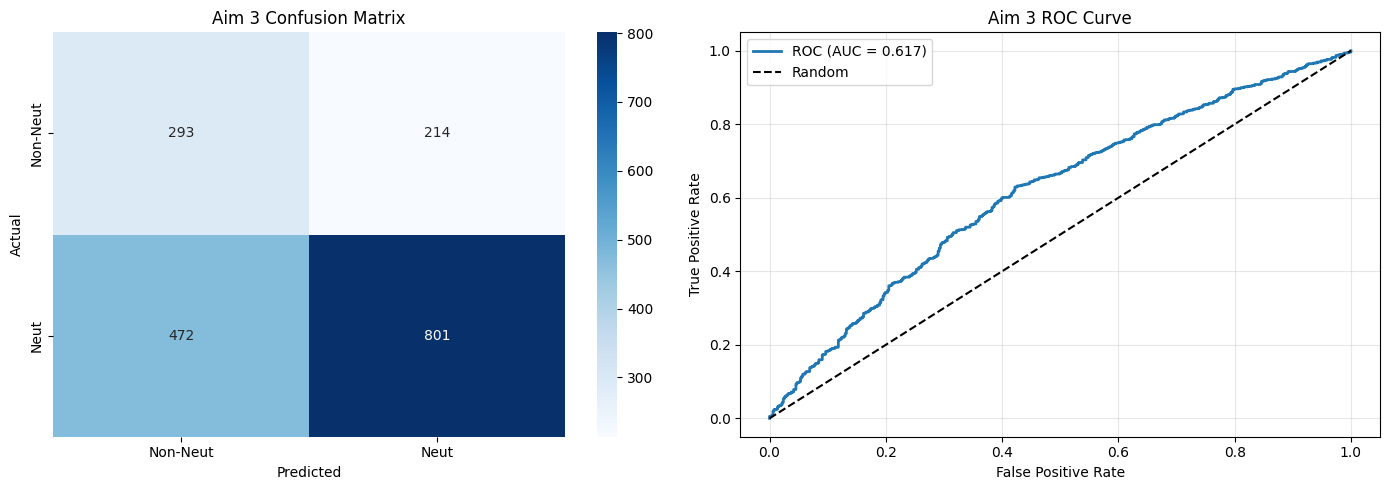

In [25]:
results = run_aim3_MAP(
    df=df_aim3,                  # DataFrame with Heavy V Gene etc.
    X_features=X_aim3,      # 2D array (n_samples, n_features)
    y_labels=all_labels,             # 1D array-like of 0/1
    feature_names=feature_names_aim3,
    min_group_size=15
)

✓ Retained 8896 samples across 9 families
Any NaNs in X_train_s? False
Any infs in X_train_s? False
X_train_s min/max: -11.377846229007204 11.10303480775999


Output()


Optimal threshold (Youden J): 0.484
Train AUC: 0.624, Test AUC: 0.615
Balanced accuracy (test): 0.593
Test Classification Report:
                   precision    recall  f1-score   support

Non-Neutralizing       0.37      0.56      0.45       507
    Neutralizing       0.78      0.63      0.69      1273

        accuracy                           0.61      1780
       macro avg       0.58      0.59      0.57      1780
    weighted avg       0.66      0.61      0.62      1780



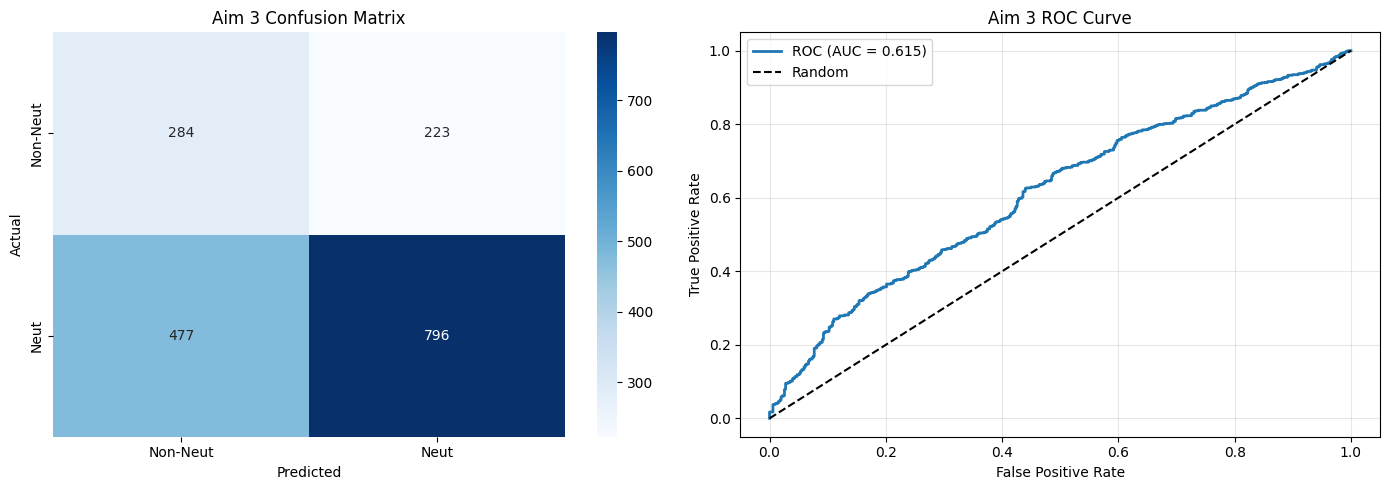

In [26]:
# Different version of Aim 3, compare whichever gives better output
all_features = coef_summary[coef_summary['feature'] != 'alpha'].copy()
all_features['abs_mean'] = np.abs(all_features['mean'])

top = all_features.nlargest(50, 'abs_mean')['feature']   # e.g. top 50

cols_for_aim3 = [c for c in feature_names if c in set(top)]
X_aim3 = X_full[cols_for_aim3].values
feature_names_aim3 = cols_for_aim3

results_aim3 = run_aim3_MAP(
    df=df_aim3,
    X_features=X_aim3,
    y_labels=all_labels,
    feature_names=feature_names_aim3,
    min_group_size=15
)